In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d ashwingupta3012/human-faces
!mkdir Dataset
!unzip -q /content/human-faces.zip -d /content/Dataset
# !rm /content/Dataset/playground-series-s3e8.zip
# https://www.kaggle.com/general/74235
# https://www.kaggle.com/datasets/ashwingupta3012/human-faces

In [1]:
from IPython.display import clear_output
clear_output()

In [2]:
!pip install -q mediapipe==0.10.0

In [2]:
import cv2 
import mediapipe as mp
from google.colab.patches import cv2_imshow
BaseOptions = mp.tasks.BaseOptions
ImageEmbedder = mp.tasks.vision.ImageEmbedder
ImageEmbedderOptions = mp.tasks.vision.ImageEmbedderOptions
VisionRunningMode = mp.tasks.vision.RunningMode

In [3]:

def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]
    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))
    resized = cv2.resize(image, dim, interpolation = inter)
    return resized


In [5]:
!wget https://storage.googleapis.com/mediapipe-models/face_detector/blaze_face_short_range/float16/1/blaze_face_short_range.tflite

--2023-06-02 05:10:13--  https://storage.googleapis.com/mediapipe-models/face_detector/blaze_face_short_range/float16/1/blaze_face_short_range.tflite
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.13.128, 74.125.26.128, 172.217.193.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.13.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 229746 (224K) [application/octet-stream]
Saving to: ‘blaze_face_short_range.tflite.4’

blaze_face_short_ra 100%[===================>] 224.36K  --.-KB/s    in 0.003s  

2023-06-02 05:10:13 (63.0 MB/s) - ‘blaze_face_short_range.tflite.4’ saved [229746/229746]



In [6]:
!wget https://storage.googleapis.com/mediapipe-models/image_embedder/mobilenet_v3_large/float32/latest/mobilenet_v3_large.tflite

--2023-06-02 05:10:13--  https://storage.googleapis.com/mediapipe-models/image_embedder/mobilenet_v3_large/float32/latest/mobilenet_v3_large.tflite
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.13.128, 74.125.26.128, 172.217.193.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.13.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10889458 (10M) [application/octet-stream]
Saving to: ‘mobilenet_v3_large.tflite.4’

mobilenet_v3_large. 100%[===================>]  10.38M  --.-KB/s    in 0.07s   

2023-06-02 05:10:13 (153 MB/s) - ‘mobilenet_v3_large.tflite.4’ saved [10889458/10889458]



In [4]:

BaseOptions = mp.tasks.BaseOptions
ImageEmbedder = mp.tasks.vision.ImageEmbedder
ImageEmbedderOptions = mp.tasks.vision.ImageEmbedderOptions
VisionRunningMode = mp.tasks.vision.RunningMode

new_options = ImageEmbedderOptions(
    base_options=BaseOptions(model_asset_path='mobilenet_v3_large.tflite'),
    l2_normalize=True,
    quantize=True,
    running_mode=VisionRunningMode.IMAGE)

embedder=ImageEmbedder.create_from_options(new_options)
def get_embadding(img):
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=img)
    embedding_result = embedder.embed(mp_image)
    embedding_list = embedding_result.embeddings[0].embedding.tolist()
    return embedding_list

import csv
import os
def save_face_data_to_csv(face_data, ids, filename):
    if not isinstance(face_data, list):
        print("Error: face_data must be a list.")
        return
    file_exists = os.path.exists(filename)
    with open(filename, 'a' if file_exists else 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        if not file_exists:
            writer.writerow(["face_data", "id"])
        
        writer.writerow([face_data, ids])
    if file_exists:
        pass 
        # print(f"Face data appended to {filename} successfully.")
    else:
        pass
        # print(f"Face data saved to {filename} successfully.")
    

In [5]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

In [6]:
base_options = python.BaseOptions(model_asset_path='blaze_face_short_range.tflite')
options = vision.FaceDetectorOptions(base_options=base_options)
detector = vision.FaceDetector.create_from_options(options)

In [7]:
def extract_facial_data(IMAGE_FILE):
    img = cv2.imread(IMAGE_FILE)
    img = image_resize(img, width=600, height=600) 
    # cv2_imshow(img)
    image = mp.Image(image_format=mp.ImageFormat.SRGB, data=img)
    img = cv2.imread(IMAGE_FILE)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    detection_result = detector.detect(image)
    if detection_result.detections:
        for detection in detection_result.detections:
            bbox = detection.bounding_box
            x1, y1 = int(bbox.origin_x),int( bbox.origin_y)
            x2, y2 = int(bbox.origin_x + bbox.width), int(bbox.origin_y + bbox.height)
            x1, y1 = x1-20, y1-170
            x2, y2 = x2+30, y2+130
            # cv2.rectangle (img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            crop_img = img[y1:y2, x1:x2]
            crop_img = image_resize(crop_img, width=480, height=480)
            crop_img = cv2.cvtColor(crop_img, cv2.COLOR_RGB2BGR)
            # cv2.imwrite("data.jpg",crop_img)
            face_data=get_embadding(crop_img) 
            save_face_data_to_csv(face_data, 0, "unknown.csv")

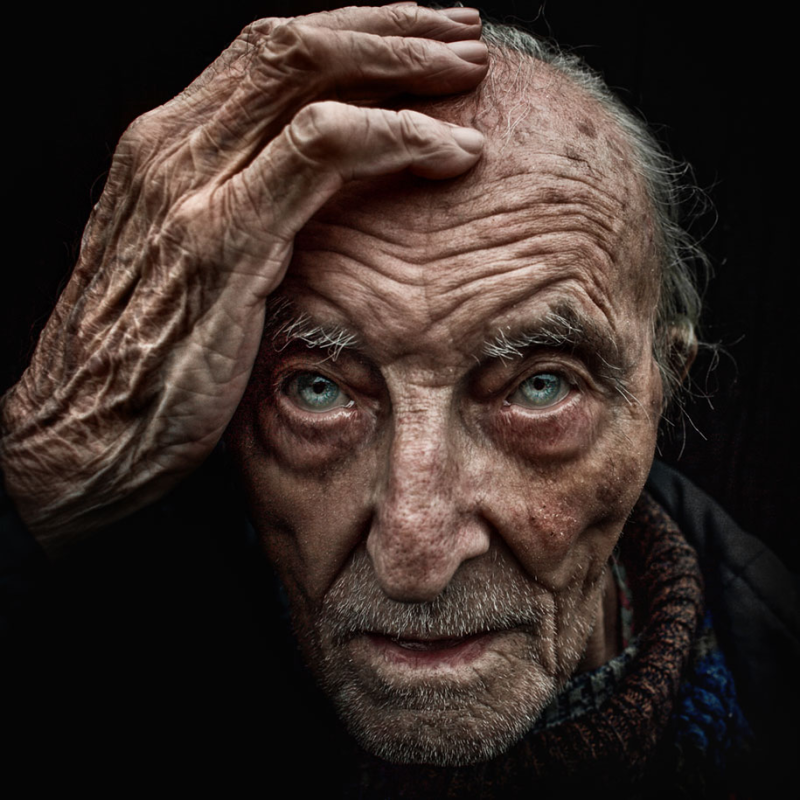

In [11]:
extract_facial_data("/content/Dataset/Humans/1 (1061).jpg")

In [8]:
import glob

def get_image_paths(directory):
    image_paths = []
    extensions = ["jpg", "jpeg", "png"]
    for ext in extensions:
        image_paths.extend(glob.glob(directory + "/*." + ext))
    return image_paths

directory = "/content/Dataset/Humans"
image_paths = get_image_paths(directory)

len(image_paths)

7201

In [ ]:
for path in image_paths[2000:3000]:
    try:
        extract_facial_data(path)
    except:
        pass

In [ ]:
batch_size = 100  # Define the batch size
total_images = len(image_paths)
num_batches = total_images // batch_size

for i in range(num_batches):
    start_index = i * batch_size
    end_index = start_index + batch_size

    batch_paths = image_paths[start_index:end_index]

    for path in batch_paths:
        try:
            extract_facial_data(path)
        except:
            pass
